<a href="https://colab.research.google.com/github/Nahid180/ColabNoteBook/blob/main/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
    

In [ ]:
train_data = torchvision.datasets.FashionMNIST('/content', download=True, train=True, transform=transforms.ToTensor(), target_transform=None)
test_data = torchvision.datasets.FashionMNIST('/content', download=True, train=False, transform=transforms.ToTensor(), target_transform=None)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
train_data[0][1]

9

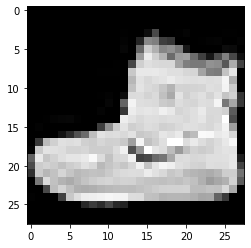

In [ ]:
plt.imshow(train_data[0][0].reshape(28,28), cmap='gray')

In [ ]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=32,
                                          shuffle=True)

test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=False)

In [ ]:
train_feature, train_label=next(iter(train_data_loader))


In [ ]:
train_label

tensor([1, 9, 9, 5, 8, 6, 7, 1, 9, 0, 2, 2, 2, 5, 6, 5, 1, 1, 4, 5, 0, 9, 0, 8,
        6, 7, 3, 3, 9, 2, 1, 0])

In [ ]:
class FashionModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=10),
        nn.ReLU()
    )
  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.stack(x)

In [ ]:
model0=FashionModelV0().to(device)

In [ ]:
next(model0.parameters()).device

device(type='xla', index=1)

In [ ]:
activation=nn.Softmax()
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model0.parameters())

In [ ]:
len(train_data_loader.dataset)

60000

In [ ]:
torch.manual_seed(42)
epochs=5

train_time_start_on_cpu = timer()

for epoch in tqdm(range(epochs)):
  train_loss=0
  for batch, (x_train, y_train) in enumerate(train_data_loader):
    x_train=x_train.to(device)
    y_train=y_train.to(device)
    model0.train()
    y_pred=model0(x_train)
    loss=loss_func(y_pred, y_train)
    train_loss+=loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%400 == 0:
      print(f"Trained {batch*len(x_train)}/{len(train_data_loader.dataset)} samples")

  train_loss=train_loss/len(train_data_loader)
  test_loss=0
  model0.eval()
  with torch.inference_mode():
    for (x_test, y_test) in test_data_loader:
      x_test=x_test.to(device)
      y_test=y_test.to(device)
      test_pred = model0(x_test)
      test_loss_batch = loss_func(y_pred, y_train)
      test_loss += test_loss_batch

    test_loss = test_loss/len(test_data_loader)
  print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model0.parameters()).device))

Train time on cpu: 48.362 seconds

Train time on cuda:0: 43.659 seconds